
# Read in Data and Merge the Train and Test sets



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

In [ ]:
# read in data sets
train = pd.read_csv('/content/fraudTrain.csv')
test = pd.read_csv('/content/fraudTest.csv')

In [ ]:
train.shape

(1296675, 23)

In [ ]:
test.shape

(555719, 23)

Data Info:


*   index - Unique Identifier for each row
* trans_date_trans_time - Transaction DateTime
* cc_num - Credit Card Number of Customer
* merchant - Merchant Name
* category - Category of Merchant
* amt - Amount of Transaction
* first - First Name of Credit Card Holder
* last - Last Name of Credit Card Holder
* gender - Gender of Credit Card Holder
* street - Street Address of Credit Card Holder
* city - City of Credit Card Holder
* state - State of Credit Card Holder
* zip - Zip of Credit Card Holder
* lat - Latitude Location of Credit Card Holder
* long - Longitude Location of Credit Card Holder
* city_pop - Credit Card Holder's City Population
* job - Job of Credit Card Holder
* dob - Date of Birth of Credit Card Holder
* trans_num - Transaction Number
* unix_time - UNIX Time of transaction
* merch_lat - Latitude Location of Merchant
* merch_long - Longitude Location of Merchant
* is_fraud - Fraud Flag <--- Target Class



In [ ]:
df = pd.concat([train, test])

In [ ]:
df.keys()

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [ ]:
df.shape

(1852394, 23)

# Data Preprocessing

In [ ]:
#drop the unusual unnamed col from the data
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
    print("Column 'Unnamed: 0' dropped.")
else:
    print("Column 'Unnamed: 0' not found, it might have been dropped already.")

print("Current columns in df:", df.columns.tolist())

Column 'Unnamed: 0' dropped.
Current columns in df: ['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']


In [ ]:
#first lets remove any duplicate entries
df_clean = df.drop_duplicates().reset_index(drop=True)

In [ ]:
df_clean.shape

(1852394, 22)

In [ ]:
#lets now check for any null values and assess what needs to be done
df_clean.isnull().sum()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


We are going to look at the boxplots for all of the numerical variables to see if there are significant outliers that have to be addressed.

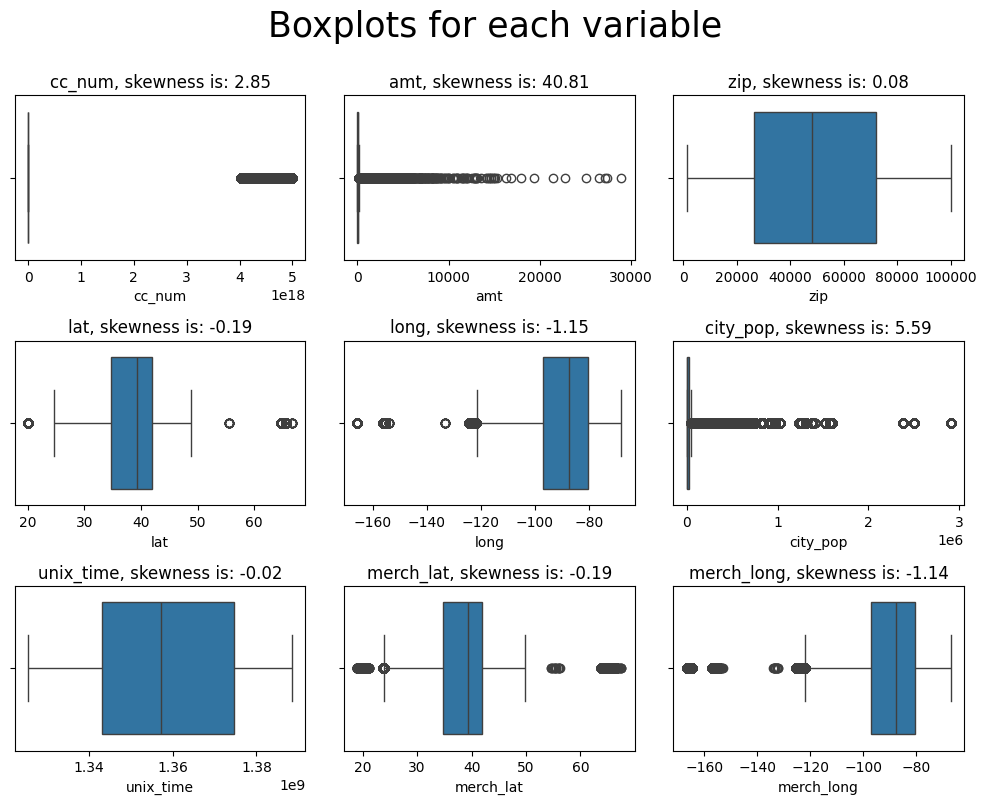

In [ ]:
#find all the columns with type int or float
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols.drop('is_fraud')

def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(10,8))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

boxplots_custom(dataset=df_clean, columns_list=numeric_cols, rows=3, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

Duplicates have been removed, and we found that the data did not include any null values for any column so we can move on with our preprocessing. Our next major step is to address the class imbalance for the is_fraud column.

In terms of outliers most of our numeric variables do not need to be concerned. For intsance, longituge and latitude are not critical to addres outliers because these values are set according to real locations. The only value that is of concern when looking at outliers would be the amount of the transaction recorded, and we see that the distribution is hevaily right skewed due to the inflation from high amount credit card purchases. While sometimes it is important to address outliers, in our case we have decided to leave them as is, as these high charges may give us better insights into the analysis of what factors indicate a fraudulent charge on a credit card.

In [ ]:
# We noticed before we selected the data, that the if_fraud variable has a very large class imbalance
# so we know this is something we need to address.
df_clean['is_fraud'].value_counts()

,count
is_fraud,
0,1842743
1,9651


In [ ]:
#Brief vizualization to illustrate the class imbalance
labels=["Genuine","Fraud"]

fraud_or_not = df_clean["is_fraud"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=df_clean['is_fraud'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Genuine transactions")
fig.show()

# We plan to use SMOTE to resample the training data to address the class imbalance, so we need to make sure all of our variables are numeric prior

In [ ]:
df_clean.keys()

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [ ]:
#address the date columns
df_clean['trans_date_trans_time'] = pd.to_datetime(df_clean['trans_date_trans_time'],format = 'mixed') #meg
df_clean['dob'] = pd.to_datetime(df_clean['dob'],format = 'mixed') #meg

# Time features
df_clean['hour'] = df_clean['trans_date_trans_time'].dt.hour
df_clean['day'] = df_clean['trans_date_trans_time'].dt.day
df_clean['month'] = df_clean['trans_date_trans_time'].dt.month
df_clean['day_of_week'] = df_clean['trans_date_trans_time'].dt.weekday

#Distance feature
if {"lat", "long", "merch_lat", "merch_long"}.issubset(df_clean.columns):
    df_clean["cust_merchant_dist"] = np.sqrt(
        (df_clean["lat"] - df_clean["merch_lat"]) ** 2 + (df_clean["long"] - df_clean["merch_long"]) ** 2
    )

# Age
df_clean['age'] = (df_clean['trans_date_trans_time'] - df_clean['dob']).dt.days / 365.25

# Drop raw columns
df_clean = df_clean.drop(['dob', 'trans_date_trans_time'], axis=1)


In [ ]:
# Frequency encoding for high-cardinality columns
for col in ['merchant', 'job', 'city', 'street']:
    freq = df_clean[col].value_counts()
    df_clean[col] = df_clean[col].map(freq)

In [ ]:
#adjust the categorical variables by making dummies for them
df_clean = pd.get_dummies(df_clean, columns=['category', 'gender', 'state'], drop_first=True, dtype=int)


In [ ]:
#drop the columns that are not needed because they are ID-like
df_clean = df_clean.drop(['cc_num', 'first', 'last', 'trans_num', 'unix_time'], axis=1)


In [ ]:
#recheck the keys and make sure we are set
df_clean.keys()

Index(['merchant', 'amt', 'street', 'city', 'zip', 'lat', 'long', 'city_pop',
       'job', 'merch_lat', 'merch_long', 'is_fraud', 'hour', 'day', 'month',
       'day_of_week', 'cust_merchant_dist', 'age', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'gender_M', 'state_AL',
       'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DC',
       'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID',
       'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA',
       'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS',
       'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ',
       'state_NM', 'state_NV', 'state_N

In [ ]:
df_clean.shape

(1852394, 82)

Create a correlation map to understand any clear relationships before moving forward.

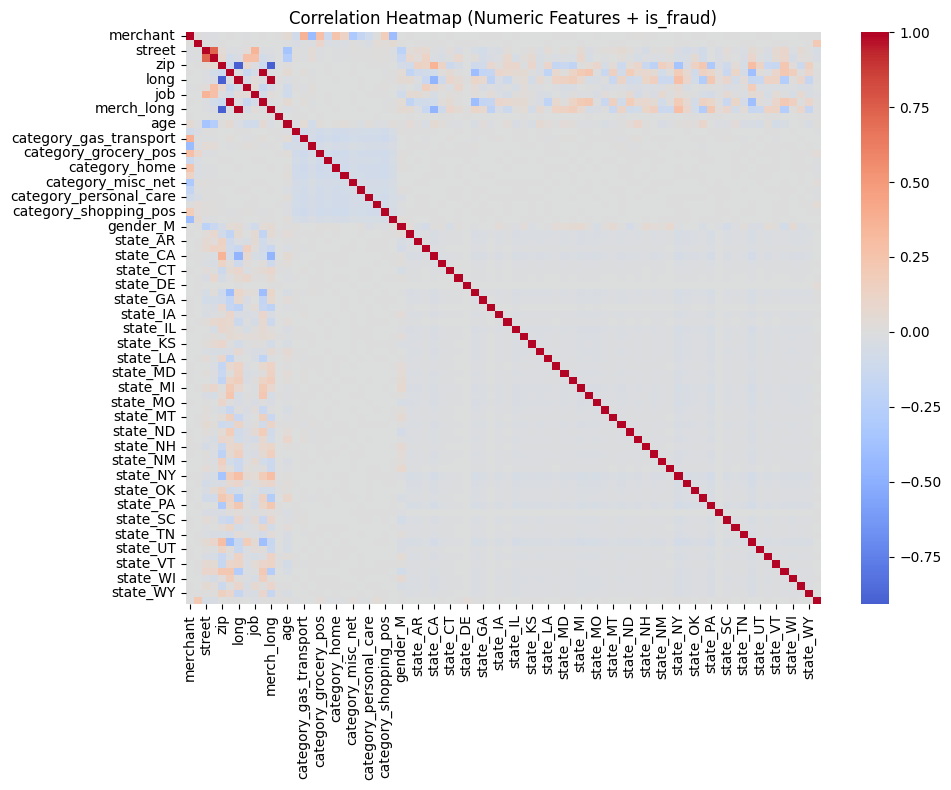

In [ ]:
#set variable for the numric columns
num_col = df_clean.select_dtypes(include=['int64', 'float64']).columns
num_col = num_col.drop('is_fraud')

#plot a correlation heatmap to understand any key relationships between our target and predictors
plt.figure(figsize=(10, 8))
corr = df_clean[num_col.tolist() + ["is_fraud"]].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features + is_fraud)")
plt.tight_layout()
plt.show()

The correlation map seems to be uninteresting for the is_fraud column, but this is due to our inherent class imbalance and the need to address it before any modeling is done.

# Handling Class Imbalance for is_fraud

In [ ]:
#before we use any resampling technique we need to split our data
from sklearn.model_selection import train_test_split

# Drop rows where 'is_fraud' is NaN- MEG
df_clean.dropna(subset=['is_fraud'], inplace=True)

X = df_clean.drop('is_fraud', axis=1)
y = df_clean['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

We are choosing to use the SMOTE technique because it addresses the severe class imbalance in the is_fraud variable by generating synthetic minority samples, which helps the model learn fraud patterns more effectively, reduces bias toward the majority class, and improves recall and precision-recall performance. SMOTE is a proven, well-validated technique in fraud detection research and integrates smoothly with modern machine learning pipelines.

In [ ]:
#scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
#use SMOTE to resample the training set
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

Before SMOTE: is_fraud
0    1474194
1       7721
Name: count, dtype: int64
After SMOTE: is_fraud
0    1474194
1    1474194
Name: count, dtype: int64


Now our data is ready to be run throuhg models. We have balanced training data in terms of our traget variable and can now properly train a model to assess credit card fraud.

# Model Selection and Evaluation

When looking at which models to select and how to proceed, considering our problem at hand (fraud detection) we want to ensure we have sufficnet models to truly see what is effective. We chose to use these three models as they represent increasing levels of model complexity. Logistic Regression provides a linear and interpretable baseline. Random Forest introduces nonlinear interactions and ensemble learning for improved performance. XGBoost adds gradient boosting, which generally offers state-of-the-art predictive accuracy for imbalanced fraud detection tasks.

In [ ]:
# use these for the models
# X_train_resampled, y_train_resampled, X_test_scaled, y_test
#import the three models logistic regression, random forest, and xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


#create the model algorithms
logr = LogisticRegression(max_iter=2000, random_state=42)
rf = RandomForestClassifier(
    n_estimators=100,               # 100 trees is plenty for a project
    max_depth=10,                   # limit depth → huge speedup
    max_features="sqrt",            # fewer features per split
    min_samples_leaf=5,             # no tiny leaves
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)
xgb = XGBClassifier(n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train) / sum(y_train)),
    random_state=42,
    n_jobs=-1)


# Logistic Regresion

Logistic Regression
Balanced Accuracy: 0.8508685229487767
Precision: 0.03805275218175613
Recall: 0.8088082901554404


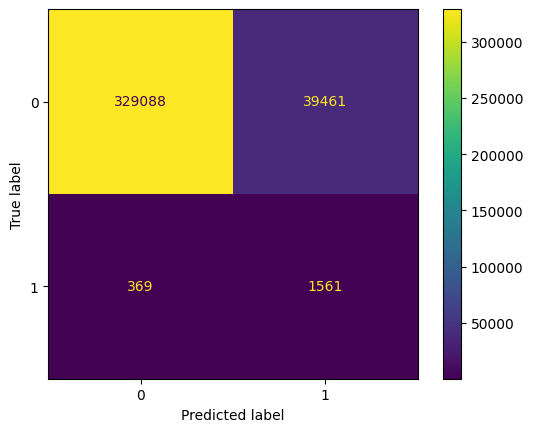

In [ ]:
#run logistic regression and print results
logr.fit(X_train_resampled, y_train_resampled)
y_pred = logr.predict(X_test_scaled)
#print metrics
print("Logistic Regression" )
logr_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
logr_precision = precision_score(y_test, y_pred)
logr_recall = recall_score(y_test, y_pred)
print("Balanced Accuracy:", logr_balanced_accuracy)
print("Precision:", logr_precision)
print("Recall:", logr_recall)

#print the nice confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),
                              display_labels=logr.classes_)
disp.plot()
plt.show()

# Random Forest

Random Forest
Balanced Accuracy: 0.91683489981584
Precision: 0.21684516726166864
Recall: 0.8497409326424871


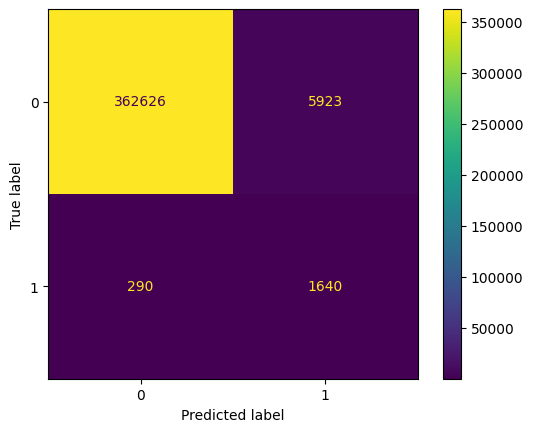

In [ ]:
#for the random forest to reduce lenghty run times we will take a subsample ofr the data
X_rf_train, _, y_rf_train, _ = train_test_split(
    X_train_resampled,
    y_train_resampled,
    train_size=0.3,         # use 30% of the SMOTE data
    stratify=y_train_resampled,
    random_state=42
)

rf.fit(X_rf_train, y_rf_train)
#run logistic regression and print results
y_pred = rf.predict(X_test_scaled)
#print metrics
print("Random Forest" )
rf_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
print("Balanced Accuracy:", rf_balanced_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)

#print the nice confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),
                              display_labels=rf.classes_)
disp.plot()
plt.show()

# XGBoost

XGBoost
Balanced Accuracy: 0.9644004318742945
Precision: 0.07571863508758056
Recall: 0.9922279792746114
F1 Score: 0.1407001947026193
ROC AUC Score: 0.9644004318742945


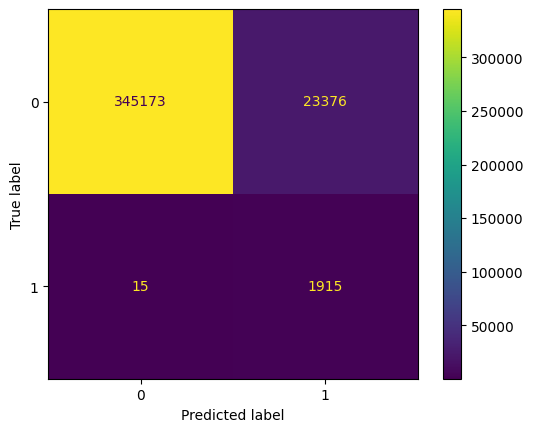

In [ ]:
#run logistic regression and print results
xgb.fit(X_train_resampled, y_train_resampled)
y_pred = xgb.predict(X_test_scaled)
#print metrics
print("XGBoost" )
xgb_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
xgb_precision = precision_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_f1 = f1_score(y_test, y_pred)
xgb_roc_auc = roc_auc_score(y_test, y_pred)
print("Balanced Accuracy:", xgb_balanced_accuracy)
print("Precision:", xgb_precision)
print("Recall:", xgb_recall)
print("F1 Score:", xgb_f1)
print("ROC AUC Score:", xgb_roc_auc)

#print the nice confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),
                              display_labels=xgb.classes_)
disp.plot()
plt.show()

From our three models, we can see that our performance does really well when it comes to predicting fraud. Especially with our XGBoost model, we have very strong recall and balanced accuracy. Because of the nature of fraud detection we want recall to be high while still keeping other metrics respectable since we would like to caputre as many fraud charges as possible. Capturing all of the fraud charges minimizes losses for banks and credit card companies. Our models seem to do very well in this category and this gives us confidence when we look to implement into fraud prediction.

In [ ]:
#print a table to illustrate the differences between the models
model_performance = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Balanced Accuracy': [logr_balanced_accuracy, rf_balanced_accuracy, xgb_balanced_accuracy],
    'Precision': [logr_precision, rf_precision, xgb_precision],
    'Recall': [logr_recall, rf_recall, xgb_recall]
})

model_performance


,Model,Balanced Accuracy,Precision,Recall
0,Logistic Regression,0.850869,0.038053,0.808808
1,Random Forest,0.916835,0.216845,0.849741
2,XGBoost,0.964400,0.075719,0.992228


# Feature Importance Evaluation


Given that our XGBoost model performed the best, we will use this model to evaluate which predictors were the most impartant for the model when classifying the fraud category.

In [ ]:
#using shapley find the effect of each feature
#import shapley
import shap
import numpy as np # Ensure numpy is imported

xgb.fit(X_train_resampled, y_train_resampled)

# Set random seed for reproducibility for numpy random operations
np.random.seed(42)

# needed to use a smaller sample because data is so large
# Fix: Sample from numpy array using np.random.choice
train_indices = np.random.choice(X_train_resampled.shape[0], 500, replace=False)
background = X_train_resampled[train_indices]

explainer = shap.TreeExplainer(xgb, background)

# Fix: Sample from numpy array using np.random.choice
test_indices = np.random.choice(X_test_scaled.shape[0], 1000, replace=False)
X_test_shap = X_test_scaled[test_indices]

shap_values = explainer.shap_values(X_test_shap)


 98%|===================| 985/1000 [00:15<00:00]       

/tmp/ipython-input-3646051642.py:2: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



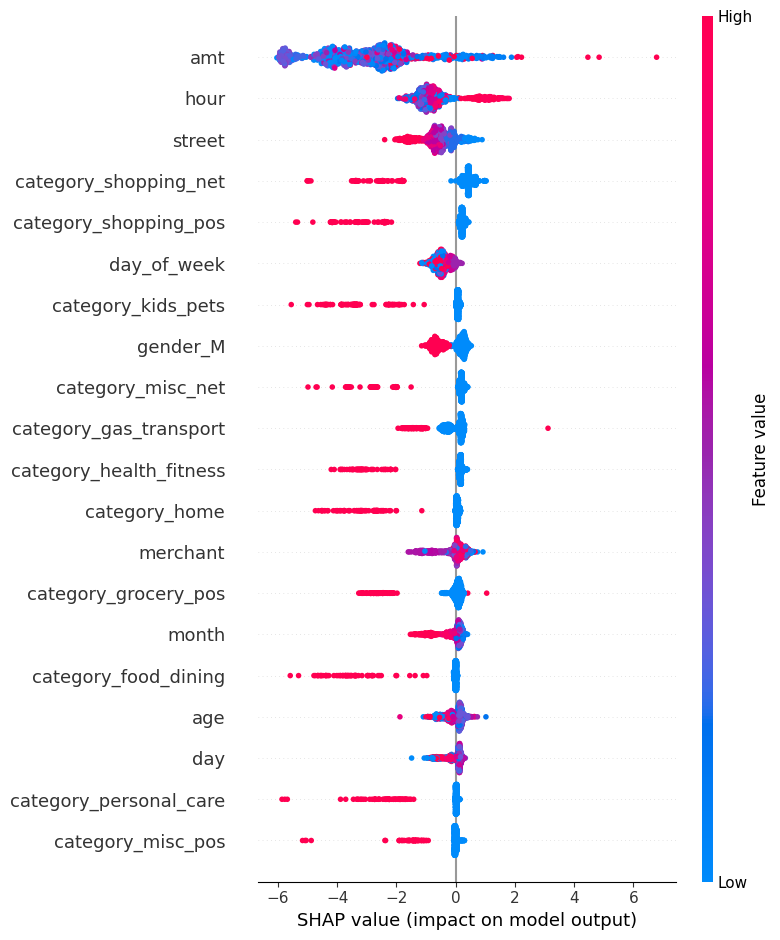

In [ ]:
#create a summary plot of the shap data
shap.summary_plot(shap_values, X_test_shap, feature_names=X_train.columns.tolist())


In [ ]:
#now lets use rfe to identify the top features and cross reference with the shap results
from sklearn.feature_selection import RFE
# sample training data for speed
n_rfe_samples = min(5000, X_train_resampled.shape[0])
idx = np.random.choice(X_train_resampled.shape[0], size=n_rfe_samples, replace=False)

X_rfe = X_train_resampled[idx]
y_rfe = y_train_resampled[idx]

rfe = RFE(xgb, n_features_to_select=3)
rfe.fit(X_rfe, y_rfe)


RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=0.8, device=None,
                            early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None,
                            feature_types=None, feature_weights=None,
                            gamma=None, grow_policy=None, importance_type=None,
                            interaction_constraints=None, learning_rate=0.05,
                            max_bin=None, max_cat_threshold=None,
                            max_cat_to_onehot=None, max_delta_step=None,
                            max_depth=6, max_leaves=None, min_child_weight=None,
                            missing=nan, monotone_constraints=None,
                            multi_strategy=None, n_estimators=300, n_jobs=-1,
                            num_parallel_tree=None, ...),
    n_features_to_select=3)

In [ ]:
#Create a table of the rankings of each predictor and sort
rankings = pd.DataFrame({'columns': X_train.columns, 'ranking': rfe.ranking_})
rankings.sort_values('ranking').head(10)


,columns,ranking
27,category_shopping_net,1
28,category_shopping_pos,1
20,category_grocery_pos,1
18,category_gas_transport,2
1,amt,3
24,category_misc_net,4
26,category_personal_care,5
21,category_health_fitness,6
22,category_home,7
17,category_food_dining,8
